<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/trile_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/nitinsaimajji/voice1.git

Cloning into 'voice1'...
remote: Enumerating objects: 629, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 629 (delta 0), reused 0 (delta 0), pack-reused 626
Receiving objects: 100% (629/629), 151.99 MiB | 25.21 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (602/602), done.


In [3]:
!pip install librosa
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
import IPython.display as ipd
filepath = "/content/voice1/dataset/female-sample-000005.wav"
ipd.Audio(filepath)

--> Librosa provides us two things , one is amplitude and other is sample rate . sample rate is the number of samples recorded per second.

--> Librosa automatically normalizes the sample rate.


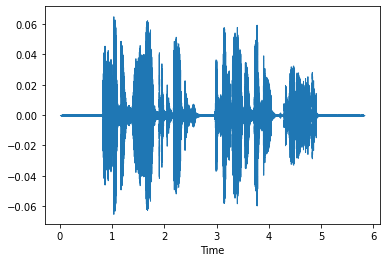

In [137]:
import librosa
import librosa.display
data, sample_rate = librosa.load(filepath)
librosa.display.waveshow(data, sr=sample_rate)

--> It tries to converge the signal into mono(one channel).

-->It can represent the audio signal between -1 to +1(in normalized form), so a regular pattern is observed.

--> It is also able to see the sample rate, and by default, it converts it to 22 kHz, while in the case of other libraries, we see it according to a different value.

In [138]:
import pandas as pd
df= pd.read_csv('/content/voice1/wav_file.csv')
df.head(5)

,filename,gender
0,male-sample-000008.wav,male
1,male-sample-000014.wav,male
2,male-sample-000019.wav,male
3,male-sample-000020.wav,male
4,male-sample-000023.wav,male


In [139]:
df['gender'].value_counts()

male      18429
female    18249
Name: gender, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


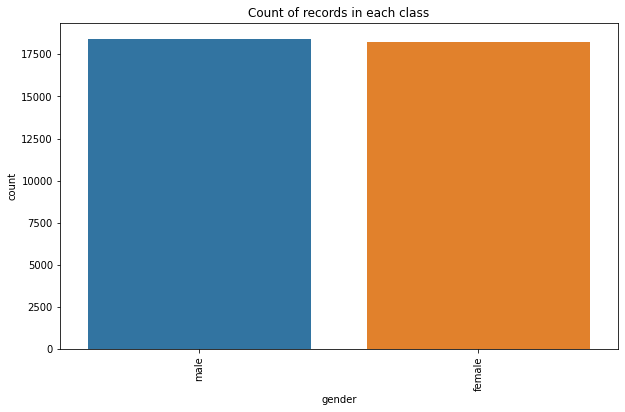

In [140]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(df['gender'])
plt.title("Count of records in each class")
plt.xticks(rotation="vertical")
plt.show()

In [141]:
df2=df.loc[df['gender']=='male'].head(300)
df.loc[df['gender']=='male']=df2
df2.shape

(300, 2)

In [142]:
df3=df.loc[df['gender']=='female'].head(300)
df.loc[df['gender']=='female']=df3
df3.shape

(300, 2)

In [143]:
frames = [df2, df3]
df= pd.concat(frames)
df.shape

(600, 2)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


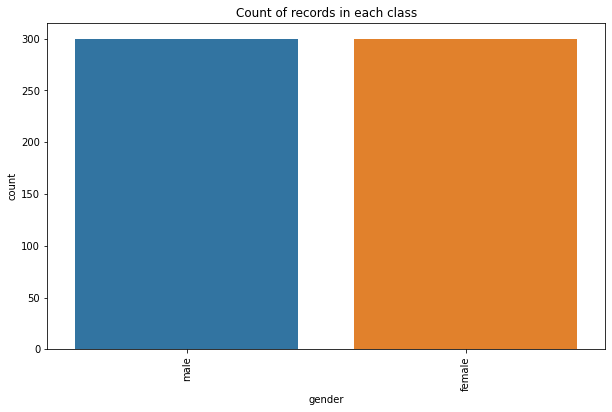

In [144]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(df['gender'])
plt.title("Count of records in each class")
plt.xticks(rotation="vertical")
plt.show()

Classes are balance now 

**Data Precrocessing**

Mel Frequency Cepstral coefficients to extract independent features from audio signals.

--> The MFCC summarizes the frequency distribution

--> it is possible to analyze both the frequency and time characteristics of the sound.

In [145]:
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [146]:
import numpy as np
from tqdm import tqdm
import os
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
path='/content/voice1/dataset'
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path)+'/',str(row["filename"]))
    final_class_labels=row["gender"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

600it [01:08,  8.77it/s]


In [147]:
features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
features_df.head()


,feature,class
0,"[-417.25986, 102.101494, -29.92257, 12.714519,...",male
1,"[-419.73123, 104.21304, 14.69646, 36.767033, 1...",male
2,"[-285.918, 131.03162, 17.004831, 17.309399, 3....",male
3,"[-228.44456, 42.38918, -18.923473, 30.334898, ...",male
4,"[-346.28073, 92.09044, -27.21604, 28.50457, 1....",male


In [149]:
features_df.to_csv('features_data.csv',index=False)

In [120]:
X=np.array(features_df['feature'].tolist())
y=np.array(features_df['class'].tolist())
### Label Encoding -> Label Encoder
from keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

## **Model Creation**

In [132]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics
### No of classes
num_labels=y.shape[1]
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))

**Compile the Model**

In [133]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

**Train the model**

In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 500
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [131]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1]*100)

11.666666716337204


2/2 [==============================] - 0s 6ms/step


ValueError: ignored